In [7]:
from time import time
import sys

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PolyCollection
import matplotlib.animation as animation

from fealpy.mesh.tree_data_structure import Quadtree
from fealpy.mesh.level_set_function import dcircle
from fealpy.mesh.simple_mesh_generator import rectangledomainmesh

In [8]:
class AdaptiveMarker():
    def __init__(self, phi):
        self.phi = phi

    def refine_marker(self, qtmesh):
        phi = self.phi

        idx = qtmesh.leaf_cell_index()
        pmesh = qtmesh.to_polygonmesh()
        cell2point = pmesh.ds.cell_to_point()

        point = qtmesh.point
        value = phi(point)
        valueSign = np.sign(value)
        valueSign[np.abs(value) < 1e-8] = 0
        NV = pmesh.number_of_points_of_cells()
        isNeedCutCell = np.abs(cell2point*valueSign).reshape(-1) != NV

        return idx[isNeedCutCell]

    def coarsen_marker(self, qtmesh):
        phi = self.phi
        NC = qtmesh.number_of_cells()
        cell = qtmesh.ds.cell
        child = qtmesh.child
        parent = qtmesh.parent

        isRootCell = qtmesh.is_root_cell()
        if np.all(isRootCell):
            return None
        else:
            point = qtmesh.point
            value = phi(point)
            valueSign = np.sign(value)
            valueSign[np.abs(value) < 1e-12] = 0

            isLeafCell = qtmesh.is_leaf_cell()
            isBranchCell = np.zeros(NC, dtype=np.bool)
            isBranchCell[parent[isLeafCell, 0]] = True 

            branchCell = cell[isBranchCell, :]
            isCoarsenCell = np.abs(np.sum(valueSign[branchCell], axis=1) 
                    + valueSign[cell[child[isBranchCell, 0], 2]]) == 5 
            idx, = np.nonzero(isBranchCell)

            return idx[isCoarsenCell]

class QuadtreeDemo():
    def __init__(self, qtree, dt):
        self.qtree = qtree
        self.dt = dt
        self.time_elapsed = 0
        self.count = 1

    def step(self, dt, marker):
        print(self.count)
        if self.count == 274:
            print(274)
        self.count += 1
        self.time_elapsed += dt
        for i in range(1):
            self.qtree.refine(marker)

        while self.qtree.coarsen(marker):
            continue

In [9]:
def init():
    return polys, 

def animate(i):
    global qtdemo, dt

    c = circle.center
    circle.center = (c[0] + 1*dt, c[1])
    circle.radius -= 0.1*dt 
    phi = lambda p: dcircle(p, circle.center, circle.radius)
    marker = AdaptiveMarker(phi)
    qtdemo.step(dt, marker)
    point = qtdemo.qtree.point
    cell = qtdemo.qtree.ds.cell
    polys.set_verts(point[cell, :])
    return polys, 

1


AttributeError: 'Quadtree' object has no attribute 'to_polygonmesh'

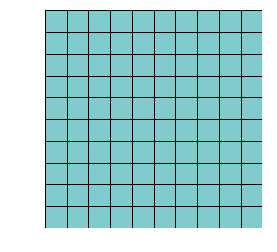

In [10]:
# initial 
box = [-1, 1, -1, 1]
cxy = (-1.5, 0.0)
r = 0.5
phi = lambda p: dcircle(p, cxy, r)
n = 10 
mesh = rectangledomainmesh(box, nx=n, ny=n, meshtype='quad')
qtree = Quadtree(mesh.node, mesh.ds.cell)

dt = 0.01
qtdemo = QuadtreeDemo(qtree, dt)

fig = plt.figure()
axes = plt.axes(xlim=(-1.,1.),ylim=(-1.,1.)) 

polys = qtdemo.qtree.add_plot(axes)
circle = Circle(cxy, r, edgecolor='g', fill=False, linewidth=2)

interval = 100 * dt 

ani = animation.FuncAnimation(fig, animate, frames=200, interval=interval, blit=True, init_func=init)

ani.save('quadtree.gif', dpi=80, writer='imagemagick')
plt.show()